In [1]:
import os
from glob import glob
import random
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt     # for plotting
import cv2 
import soundfile as sf

import librosa
import pandas as pd
from IPython.display import Audio
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from collections import Counter

from time import process_time

tf.keras.backend.clear_session()

**Global Variables**

In [2]:
# Data path:
data_path = '../data/'
speakers_path = '../SPEAKERS.TXT'

sample_rate = 32000
off_set = 0
duration = 5.0

# If you decide to use batch sizes:
batch_size = 10000

sample_size = (round((sample_rate*duration)), 1)

**Helper Functions**

In [3]:
def extract_id_sex():
    id_sex_array = []
    with open(speakers_path, 'r') as file:
        # Skip the header line
        next(file)
        for line in file:
            # Split the line into columns
            columns = line.split('|')
            # Extract the ID and SEX
            id_value = columns[0].strip()
            sex_value = columns[1].strip()
            # Append ID and SEX to the array
            id_sex_array.append((id_value, sex_value))
    return id_sex_array

# Lets store the speaker gender, it'll only be used once.
speaker_gender = extract_id_sex()

def load_directory():
    # Find all samples in the directory
    files = glob(os.path.join(data_path, '*.flac'))
    # The audio data
    x = []
    # The gender and speaker ID
    y = []

    # Create a dictionary for speaker genders
    speaker_gender_dict = {speaker[0]: speaker[1] for speaker in speaker_gender}

    counter_f = 0
    counter_m = 0
    speakers = []

    if batch_size > len(files):
        error_msg = f'Requested a batch size greater than the number of samples available ({len(files)})'
        raise ValueError(error_msg)

    for file in files:
        if (len(x) == batch_size):
            break
        
        # Collect the speaker IDs, because we are classifying on gender the speakerID does not 
        # matter as a label, but it does help us ensure we have a diverse representation of 
        # speakers for each gender, so we will only take 1 sample per speaker for each gender.
        fileName = file.split('\\')[1]
        speakerId = fileName.split('-')[0]

        # Due to limited number of samples per speaker limit the below code to 14500
        if batch_size < 14500:
            # extract an even number of samples from each speaker ensuring we get a diverse
            # range of speakers 
            num_samples_per_speaker = round(batch_size / 250)
            speaker_count = Counter(speakers)
            if (speaker_count[speakerId] >= num_samples_per_speaker):
                continue
        
        # Use dictionary for faster search performance.
        gender = speaker_gender_dict.get(speakerId)

        if (gender == 'F' and (counter_f < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((0, speakerId))
            speakers.append(speakerId)
            counter_f = counter_f + 1

        elif (gender == 'M' and (counter_m < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((1, speakerId))
            speakers.append(speakerId)
            counter_m = counter_m + 1

    return np.array(x), np.array(y, dtype=int)

# Function to extra time preformance from a model,
# prints the training and inference (testing) time
def get_time_performance(model, train_start, train_end, x_test):
    test_pred_start = process_time()
    model.predict(x_test)
    test_pred_end = process_time()

    train_time = train_end - train_start
    inference_test_time = test_pred_end - test_pred_start
    print('Training Time: %f\n Inference Time (testing set): %f' % \
        (train_time, inference_test_time))

**Load the data**</br>
Preform any pre-processing neccesary, in this case we want:</br>
1. Trim the samples to all be 5 seconds. 
Other than that, the raw data will be used on a 1D network. 

In [4]:
x_data, y = load_directory()
# Information on the extracted audio data:
print(f'x data, first sample: {x_data[0]}')
print(f'shape x data: {x_data.shape}')

y_data = np.array([row[0] for row in y])
print("first 10 y data: " + str(y_data[:10]))
speakerIds = [row[1] for row in y]
print(f'shape y data: {y_data.shape}')

f_rows = y[y[:, 0] == 0]
m_rows = y[y[:, 0] == 1]
print()
print(f'Female Speakers - {len(np.unique(f_rows[:, 1]))} : {np.unique(f_rows)}')
print(f'Male Speakers - {len(np.unique(m_rows[:, 1]))}: {np.unique(m_rows)}')

x data, first sample: [-0.00629657 -0.00675512 -0.00572782 ... -0.01366212 -0.01157286
 -0.00571476]
shape x data: (10000, 160000)
first 10 y data: [0 0 0 0 0 0 0 0 0 0]
shape y data: (10000,)

Female Speakers - 125 : [   0   19   32   39   40   83   87   89  103  125  150  198  200  211
  226  248  250  289  298  302  322  328  403  426  441  587  669  696
  730  887 1069 1088 1098 1116 1183 1246 1263 1363 1447 1502 1553 1578
 1737 1841 1898 1926 1963 1970 1992 2007 2092 2182 2196 2391 2416 2691
 2764 2817 2836 2910 2989 3112 3235 3259 3440 3526 3879 3947 3982 3983
 4051 4088 4137 4160 4195 4214 4297 4340 4362 4481 4640 4680 4853 5022
 5163 5339 5393 5514 5561 5652 5688 5778 5789 5867 6000 6064 6078 6147
 6272 6385 6415 6476 6531 6818 7059 7078 7113 7148 7178 7302 7511 7517
 7635 7780 7794 7800 7859 8014 8051 8123 8238 8312 8324 8465 8468 8975]
Male Speakers - 126: [   1   26   27   60   78  118  163  196  201  229  233  254  307  311
  332  374  405  412  445  446  458  460  481  625

In [5]:
for speaker in m_rows[:,1]:
    num_samples = np.sum(m_rows[:, 1] == speaker)
    print(f"Number of samples for male speaker {speaker}: {num_samples}")

for speaker in f_rows[:,1]:
    num_samples = np.sum(f_rows[:, 1] == speaker)
    print(f"Number of samples for female speaker {speaker}: {num_samples}")

Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speaker 1034: 40
Number of samples for male speak

**Split the data**
Split into training, Testing and Validation. 
1. Equal amount of samples of each speaker 
2. 70 - 30 split, training and remainder from x_data 
3. 50-50 split, validation and testing from remainder

In [6]:
x_train, x_remain, y_train, y_remain = train_test_split(x_data, y_data, 
                                                        test_size=0.6, 
                                                        random_state=42, 
                                                        shuffle=True,
                                                        stratify=y_data)

In [7]:
# Sanity check the split data:
print(f'x train: {x_train[0]}')
print(f'shape x train: {x_train.shape}')
print(f'shape y train: {y_train.shape}')

x train: [-0.00014683 -0.00012331 -0.00012729 ... -0.04876486 -0.03797076
 -0.0182764 ]
shape x train: (4000, 160000)
shape y train: (4000,)


In [8]:
x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                shuffle=True,
                                                stratify=y_remain)

In [9]:
print()
print('Validation Data:')
print(f'x train: {x_val[0]}')
print(f'shape x train: {x_val.shape}')
print(f'shape y train: {y_val.shape}')

print()
print('Testing Data:')
print(f'x train: {x_test[0]}')
print(f'shape x train: {x_test.shape}')
print(f'shape y train: {y_test.shape}')


Validation Data:
x train: [-0.00441258 -0.01029193 -0.01267621 ...  0.01617835  0.01291065
  0.00627513]
shape x train: (3000, 160000)
shape y train: (3000,)

Testing Data:
x train: [-0.00407648 -0.00343831 -0.00129383 ...  0.06566975  0.0567381
  0.02908233]
shape x train: (3000, 160000)
shape y train: (3000,)


Text(0.5, 1.0, 'Testing Data')

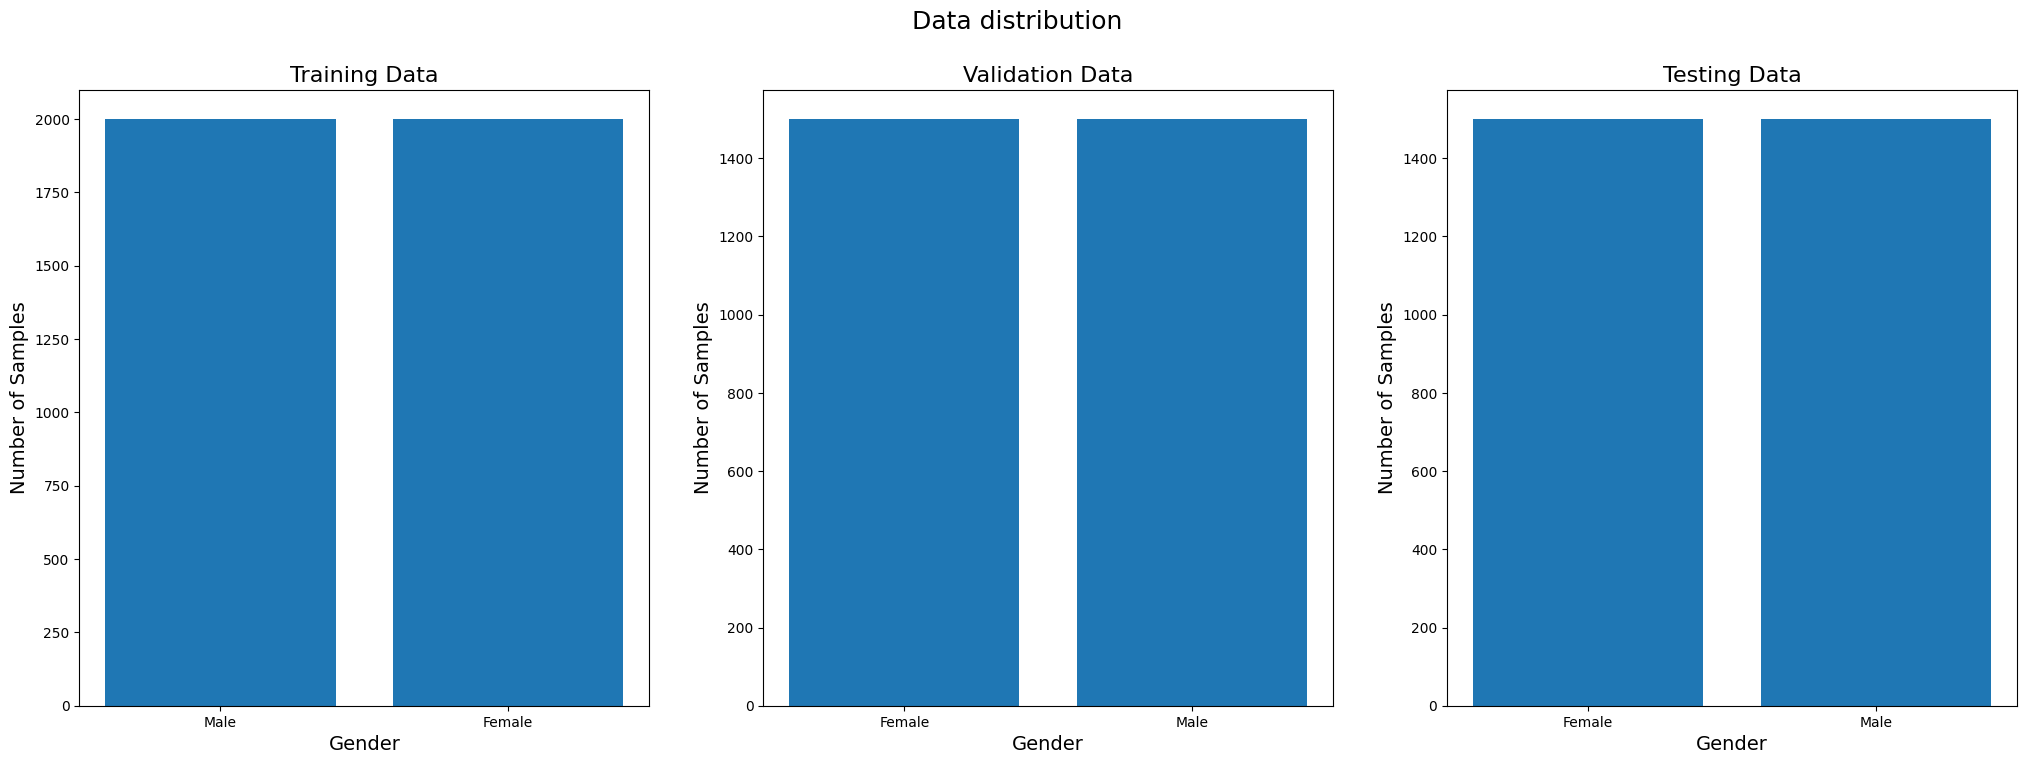

In [10]:
# Data distribution of samples per speaker
fig = plt.figure(figsize=[25, 8])
fig.suptitle("Data distribution", fontsize=18)
ax = fig.add_subplot(1,3,1)
gender, samples = np.unique(y_train, return_counts=True)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Male", "Female"])
ax.bar(gender, samples)
ax.set_xlabel("Gender", fontsize=14)
ax.set_ylabel("Number of Samples", fontsize=14)
ax.set_title("Training Data", fontsize=16)

ax = fig.add_subplot(1,3,2)
gender, samples = np.unique(y_val, return_counts=True)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Female", "Male"])
ax.bar(gender, samples)
ax.set_xlabel("Gender", fontsize=14)
ax.set_ylabel("Number of Samples", fontsize=14)
ax.set_title("Validation Data", fontsize=16)

ax = fig.add_subplot(1,3,3)
gender, samples = np.unique(y_test, return_counts=True)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Female", "Male"])
ax.bar(gender, samples)
ax.set_xlabel("Gender", fontsize=14)
ax.set_ylabel("Number of Samples", fontsize=14)
ax.set_title("Testing Data", fontsize=16)

**Data Augmentation** </br>
Adding a bit of noise to our training data for a more diverse data set.

In [11]:
def data_augmentation(audio_sample, noise):
    # Apply random pitch shifting
    pitch_shifted_audio = librosa.effects.pitch_shift(audio_sample, sr=sample_rate, n_steps=np.random.uniform(-1, 1))
    # Apply random noise addition
    noise = np.random.normal(0, noise, len(audio_sample))

    noisy_audio = audio_sample + pitch_shifted_audio + noise

    # Normalize the augmented audio
    noisy_audio /= np.max(np.abs(noisy_audio))
    
    return noisy_audio

# Randomly select 1 % of the data to be augmented
one_percent = round(batch_size * 0.01)
augmented_indices = random.sample(range(batch_size), one_percent)

# Apply data augmentation techniques
for idx in augmented_indices:
    x_data[idx] = data_augmentation(x_data[idx], 0.01)

In [12]:
# Listen to the samples to ensure theyre still understandable
idx = augmented_indices[0]
print(f'Sample 1: {idx}')
Audio(data=x_data[idx], rate=sample_rate)

Sample 1: 2138


In [13]:
idx = augmented_indices[10]
print(f'Sample 2: {idx}')
Audio(data=x_data[idx], rate=sample_rate)

Sample 2: 4772


In [14]:
idx = augmented_indices[99]
print(f'Sample 3: {idx}')
Audio(data=x_data[idx], rate=sample_rate)

Sample 3: 3497


**Base VGG Network**

In [15]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv1D(filters=filters, kernel_size=15, activation='relu')(inputs)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout1D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool1D(pool_size=16, strides=16)(x)
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size)(inputs)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

In [16]:
embedding_size = 2
dummy_input = keras.Input(sample_size)
base_network = vgg_net(dummy_input, [16, 32, 64], [128], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
# Add the classification head
classification_output = layers.Dense(1, activation='sigmoid', name='classification_layer')(embedding_layer)
vgg_network = keras.Model(dummy_input, classification_output, name='Output')

In [17]:
vgg_network.summary()

Model: "Output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160000, 1)]       0         
                                                                 
 conv1d (Conv1D)             (None, 159986, 16)        256       
                                                                 
 spatial_dropout1d (SpatialD  (None, 159986, 16)       0         
 ropout1D)                                                       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9999, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 9985, 32)          7712      
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 9985, 32)         0    

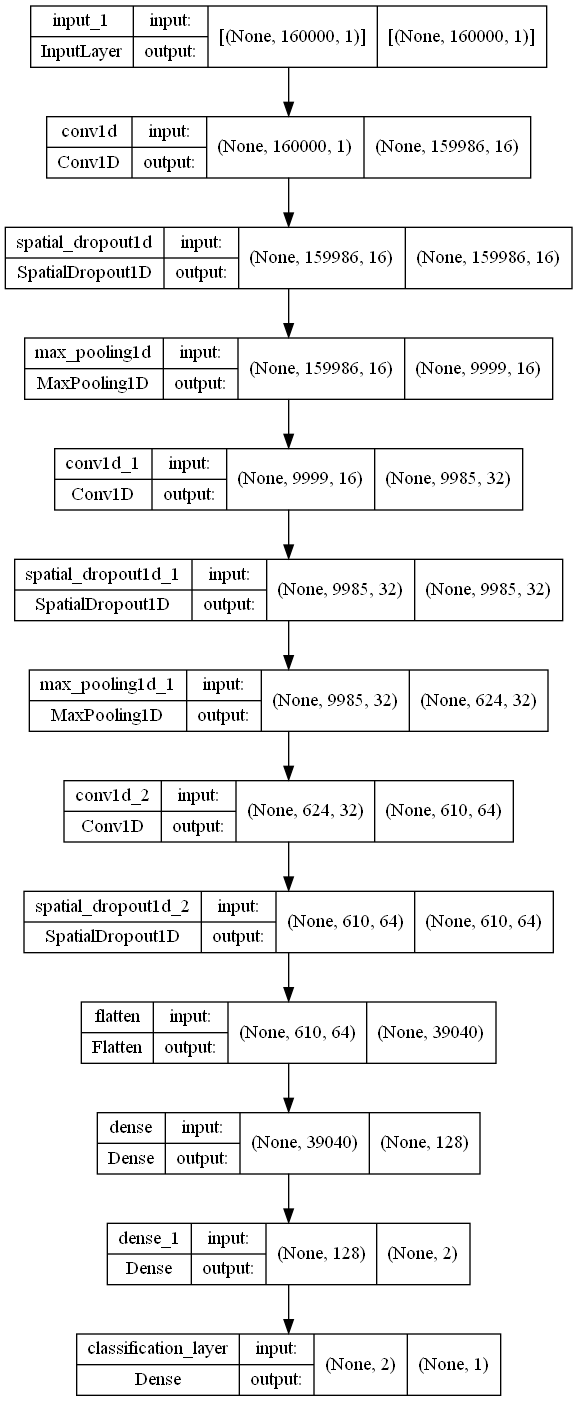

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(vgg_network, show_shapes=True)

In [19]:
train_time_start = process_time()
# Compile the model
vgg_network.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# set up early stopping to monitor validation loss, if it doesnt improve in 5 sequential occurences then it stops.
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
history = vgg_network.fit(x_train, y_train,
                epochs=100,
                batch_size=128,
                callbacks=[callback],
                validation_data=(x_val, y_val))

train_time_end = process_time()

Epoch 1/100
32/32 [==============================] - 166s 4s/step - loss: 0.7280 - accuracy: 0.5163 - val_loss: 0.6708 - val_accuracy: 0.5673
Epoch 2/100
32/32 [==============================] - 116s 4s/step - loss: 0.6149 - accuracy: 0.6513 - val_loss: 0.4150 - val_accuracy: 0.8483
Epoch 3/100
32/32 [==============================] - 117s 4s/step - loss: 0.4554 - accuracy: 0.8230 - val_loss: 0.2815 - val_accuracy: 0.9023
Epoch 4/100
32/32 [==============================] - 118s 4s/step - loss: 0.3582 - accuracy: 0.8602 - val_loss: 0.2325 - val_accuracy: 0.9157
Epoch 5/100
32/32 [==============================] - 115s 4s/step - loss: 0.2983 - accuracy: 0.8845 - val_loss: 0.2201 - val_accuracy: 0.9227
Epoch 6/100
32/32 [==============================] - 117s 4s/step - loss: 0.3003 - accuracy: 0.8975 - val_loss: 0.2132 - val_accuracy: 0.9210
Epoch 7/100
32/32 [==============================] - 118s 4s/step - loss: 0.2477 - accuracy: 0.9070 - val_loss: 0.1928 - val_accuracy: 0.9283
Epoch 

**The results**

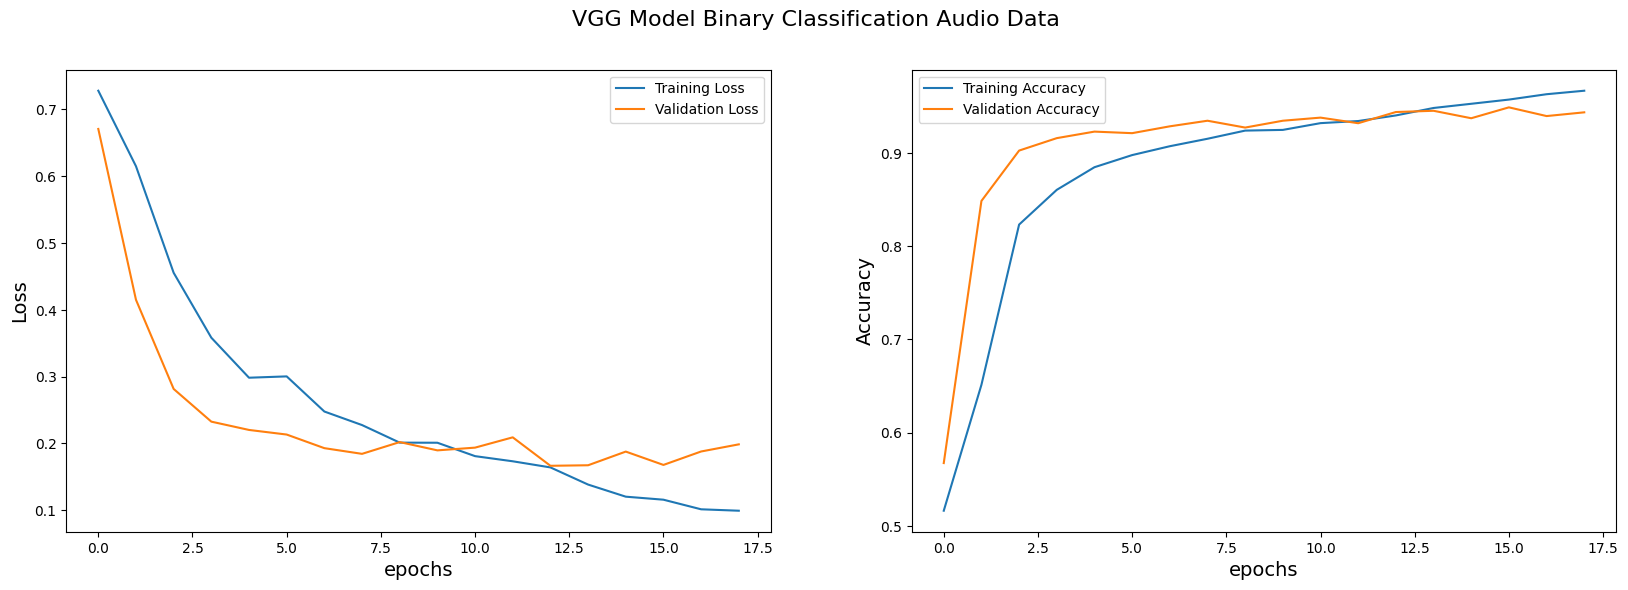

In [35]:
# Function to plot the epoch preformance
def plot_model_history(model_history, title):
    fig = plt.figure(figsize=[20, 6])
    fig.suptitle(title, fontsize=16)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(model_history.history['loss'], label="Training Loss")
    ax.plot(model_history.history['val_loss'], label="Validation Loss")
    ax.legend()
    ax.set_xlabel("epochs", fontsize=14)
    ax.set_ylabel("Loss", fontsize=14)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(model_history.history['accuracy'], label="Training Accuracy")
    ax.plot(model_history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend()
    ax.set_xlabel("epochs", fontsize=14)
    ax.set_ylabel("Accuracy", fontsize=14)

plot_model_history(history, "VGG Model Binary Classification Audio Data")

c:\Users\Sama Al kamachy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
c:\Users\Sama Al kamachy\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


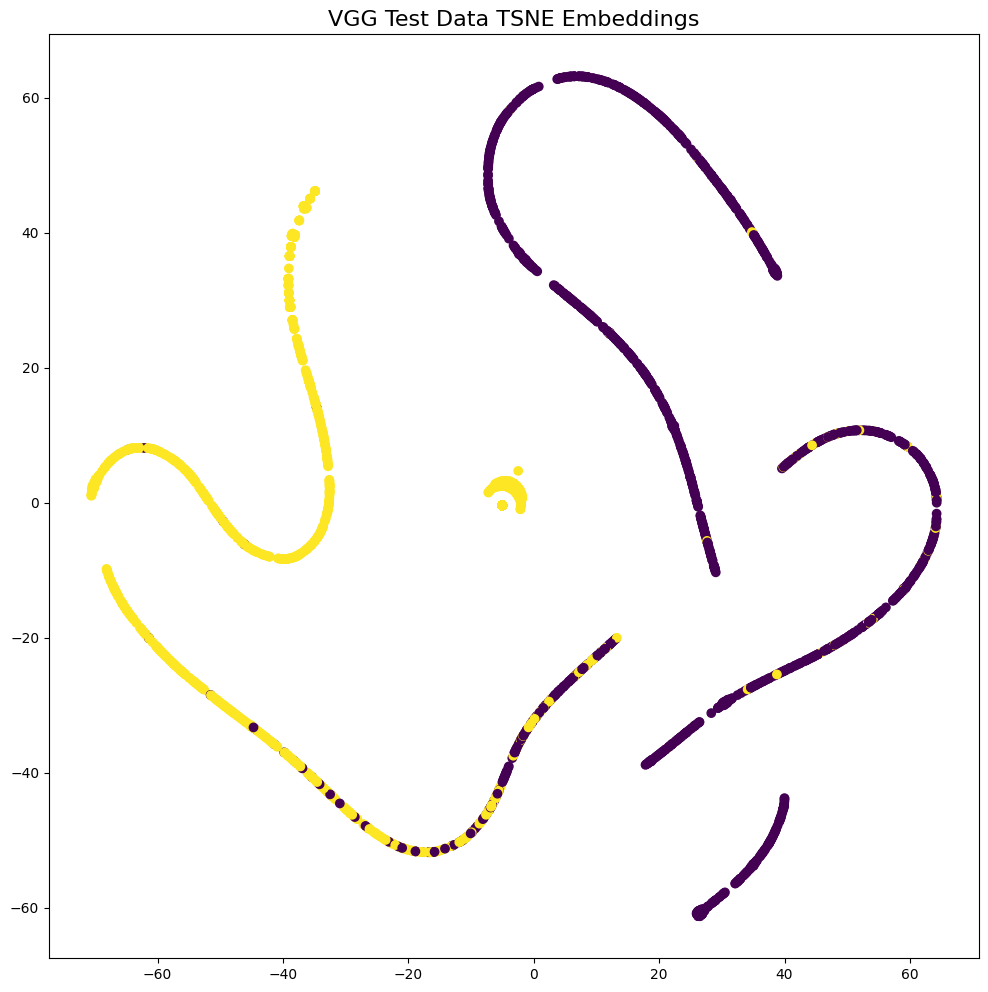

In [29]:
from sklearn.manifold import TSNE

test_embeddings = vgg_network.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(test_embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.set_title("VGG Test Data TSNE Embeddings", fontsize=16)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test.flatten());

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1500
           1       0.94      0.95      0.94      1500

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



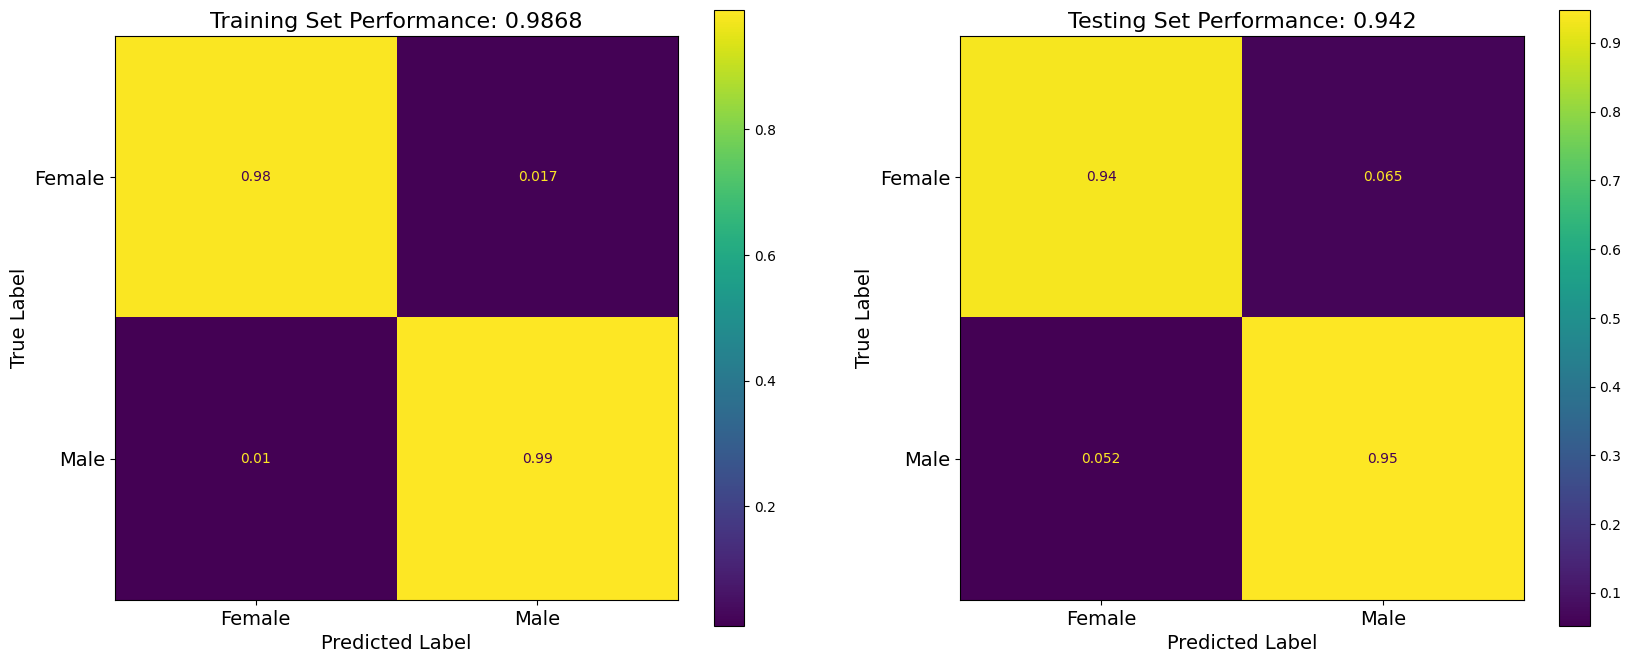

In [34]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
def eval_dnn(model, X_train, Y_train, X_test, Y_test, threshold = 0.5):
    display_labels = ['Female', 'Male']
    fig = plt.figure(figsize=[20, 8])
    ax = fig.add_subplot(1, 2, 1)
    pred = model.predict(X_train, verbose=False) > threshold    
    conf = ConfusionMatrixDisplay.from_predictions(y_true = Y_train, y_pred = pred, normalize='true', ax=ax)
    conf.ax_.set_title('Training Set Performance: ' + str(round(f1_score(Y_train, pred), 4)), fontsize=16);
    conf.ax_.set_xticklabels(display_labels, fontsize=14)
    conf.ax_.set_yticklabels(display_labels, fontsize=14)
    conf.ax_.set_xlabel('Predicted Label', fontsize=14)
    conf.ax_.set_ylabel('True Label', fontsize=14)

    ax = fig.add_subplot(1, 2, 2)
    pred = model.predict(X_test, verbose=False) > threshold    
    conf = ConfusionMatrixDisplay.from_predictions(y_true = Y_test, y_pred = pred, normalize='true', ax=ax)
    conf.ax_.set_title('Testing Set Performance: ' + str(round(f1_score(Y_test, pred), 4)), fontsize=16);
    print(classification_report(Y_test, pred))
    conf.ax_.set_xticklabels(display_labels, fontsize=14)
    conf.ax_.set_yticklabels(display_labels, fontsize=14)
    conf.ax_.set_xlabel('Predicted Label', fontsize=14)
    conf.ax_.set_ylabel('True Label', fontsize=14)

eval_dnn(vgg_network, x_train, y_train, x_test, y_test)

**Preformance**

In [23]:
get_time_performance(vgg_network, train_time_start, train_time_end, x_test)

Training Time: 20756.625000
 Inference Time (testing set): 158.500000
